# Edit Delta Analysis

This notebook implements some metrics we came up with ourselves. These Metrics utilize the `size` column which indicates the size of the Article in bytes after the edit was made. A Delta between two successive edits can thus be easily inferred. Our hypothesis is that higher fluctuations in the sign of successive deltas (indicating repeated additions & deletions) should correlate with edit-warring behavior.

As a First step, the edit logs are read, along with a dictionary of all articles belonging to the three selected topics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


ip_df = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-14-11-41.csv")
ua_df = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-22-44.csv")
cw_df = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-11-03.csv")
all_df = pd.concat([ip_df, ua_df, cw_df])

pd.set_option('mode.chained_assignment', None) # suppress CopyWarning

topics = {
    'Ukraine' : 
        ["Kyiv","Kievan_Rus'","Stepan_Bandera","Bohdan_Khmelnytsky","Cossacks","Ukrainian_language","Holodomor","Borscht","Symon_Petliura",
        "Ukrainian_People's_Republic","Mykhailo_Hrushevsky","Nikolai_Gogol","Taras_Shevchenko","Ukrainian_literature","Ivan_Franko","Ukrainian_Insurgent_Army","Organisation_of_Ukrainian_Nationalists","Pierogi",
        "Kolach_(bread)", "Paska_(bread)", "Pampushka", "Syrniki", "Rusyns", "Vyshyvanka", "Ukrainian_Soviet_Socialist_Republic", "Pereiaslav_Agreement", "West_Ukrainian_People's_Republic", 
        "Massacres_of_Poles_in_Volhynia_and_Eastern_Galicia", "Orange_Revolution", "Ukrainian_War_of_Independence", "Principality_of_Kiev", "Kyiv_Pechersk_Lavra","Golden_Gate,_Kyiv", "Bakhchysarai_Palace", 
        "Khreshchatyk", "Kamianets-Podilskyi_Castle",  "Saint_Sophia_Cathedral,_Kyiv", "Kobzar", "Hryhorii_Skovoroda", "Lesya_Ukrainka", "Rus'_people", "Zaporozhian_Cossacks", "Khmelnytsky_Uprising"],
    'Israel/Palestine' : 
        ["Nakba","Mandatory_Palestine","1948_Arab-Israeli_War","David_Ben-Gurion","Yasser_Arafat","Six-Day_War","Yom_Kippur_War","Hummus","Falafel","Shawarma","First_Intifada",
        "United_Nations_Partition_Plan_for_Palestine", "Intercommunal_conflict_in_Mandatory_Palestine", "Lehi_(militant_group)", "Irgun", "Ze'ev_Jabotinsky",
        "Haganah", "1947–1948_civil_war_in_Mandatory_Palestine", "1948_Arab–Israeli_War", "Yitzhak_Rabin", "Palmach", "Moshe_Dayan", "Jewish_exodus_from_the_Muslim_world", 
        "1936–1939_Arab_revolt_in_Palestine", "Amin_al-Husseini", "1948_Palestinian_expulsion_and_flight", "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war", "Plan_Dalet", 
        "Abd_al-Qadir_al-Husayni", "1929_Hebron_massacre", "Causes_of_the_1948_Palestinian_expulsion_and_flight", "Deir_Yassin_massacre", "Menachem_Begin", "Kfar_Etzion_massacre", "Hebrew_language", 
        "Suez_Crisis", "Six-Day_War", "Egypt–Israel_peace_treaty", "Palestinian_Arabic", "Culture_of_Palestine", "Palestinian_cuisine", "Samih_al-Qasim", "Mahmoud_Darwish", "Origin_of_the_Palestinians"],
    'US_Civil_War' : 
        ["Ulysses_S._Grant","Sherman's_March_to_the_Sea","William_Tecumseh_Sherman","Union_Army","Confederate_States_Army","Robert_E._Lee","Joseph_E._Johnston","Alexander_H._Stephens","James_Longstreet",
        "United_Daughters_of_the_Confederacy","Army_of_Northern_Virginia","Jefferson_Davis","Origins_of_the_American_Civil_War","Confederate_States_of_America","Abraham_Lincoln","Battle_of_Gettysburg", 
        "Judah_P._Benjamin", "John_C._Breckinridge", "Joseph_Wheeler", "P._G._T._Beauregard", "Franklin_Buchanan", "Nathan_Bedford_Forrest", "Ku_Klux_Klan", "John_C._Frémont", "Joseph_Hooker", "George_Meade", 
        "Wilmington_massacre", "Red_Shirts_(United_States)", "United_Confederate_Veterans", "Confederate_History_Month", "Robert_E._Lee_Day", "Stonewall_Jackson", "Jim_Crow_laws", "John_Brown_(abolitionist)", 
        "William_Lloyd_Garrison", "Frederick_Douglass", "Thaddeus_Stevens", "Battle_of_the_Wilderness", "Battle_of_Antietam", "Reconstruction_era", "Emancipation_Proclamation", 
        "Thirteenth_Amendment_to_the_United_States_Constitution", "Slavery_in_the_United_States", "States'_rights", "Historiographic_issues_about_the_American_Civil_War"],
}


## Delta Analysis

The following cell defines a number of functions used to conduct the analysis of edit deltas.

* `prepare_df`: Filters for a particular language and article, orders edits within that article and then calculates the delta of size between successive edits, along with a flag where 1 indicates that the previous edit's delta had a different sign than the current. Also ads a flag if the editing username is an ip address (i.e. anonymous user).
* `get_monthly_jerk`: This uses the filtered dataframe returned by `prepare_df` and returns a monthly aggregation of sign changes (referred to as "jerkiness")
* `time_series_analysis`: This function generates 4 different plots:
    * **Edit Delta over time:** A lineplot of deltas over time, wild fluctuations indicate big changes to an article, often related to vandalism and corresponding reverts.
    * **Article Size over time:** A lineplot of the articles size over time, using a rolling window to smoothen the plot a bit. This illustrates if the article actually grew during times of contention.
    * **Monthly fraction of anonymous edits over time:** This scatterplot shows the fraction of anonymous editors compared to account users over time. This can be used to investigate the hypothesis that it is mostly non-registered users that commit e.g. acts of vandalism. Once a protection is placed, this fraction should be 0. Circle size indicates total number of edits in that month.
    * **Monthly fraction of Sign changes/Total edits over time:** This visualizes the jerk metric by plotting the monthly fraction of sign-changing edits / total edits. Circle size indicates total number of edits in that month.
* `plot_edit_delta_distribution`: This function shows the distribution of edit deltas during the whole lifespan of an article. A right skewed histogram would indicate an article that is mostly growing, while a distribution that is more centered around 0 would indicate a contested article.
* `analyze_article_deltas`: A wrapper calling both `time_series_analysis` & `plot_edit_delta_distribution`.

In [2]:

def prepare_df(df: pd.DataFrame, article: str, lang: str):
    """filters for an article and language, sorts by timestamp and adds
    edit_delta, sign_delta, sign_change + ads is anon_uname flag
    """
    # filter article and language
    df = df[(df["article"]==article) & (df["language"]==lang)]
    # sort by timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    # calc edit delta
    df['edit_delta'] = df['size'].diff()
    df.dropna(subset=['edit_delta'], inplace=True) # should only be the first
    # sign 0.5 for positive, -0.5 for negative - sign change is 1
    df['sign_delta'] = np.sign(df['edit_delta']) / 2
    df['sign_change'] = df['sign_delta'].diff().fillna(0).abs()
    df['month_year'] = df['timestamp'].dt.to_period('M')
    # regex match ip adresses and flag 'em
    ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    df["is_anon_uname"] = df['user'].str.match(ip_pattern)
    df["frac_edits_on_this_article"] = df["article_edits"] / df["total_edits"]

    return df


def get_monthly_jerk(df: pd.DataFrame):
    """assumes the df already has
    * edit_delta
    * is filtered for one article and language
    Returns aggregated monthly sign changes df
    """
    # Group by month and year, calculate the required metrics
    monthly_stats = df.groupby('month_year').agg(
        num_edits=('edit_delta', 'size'),
        num_sign_changes=('sign_change', 'sum')
    ).reset_index()
    # Calculate the number of sign changes relative to the total number of edits
    monthly_stats['relative_sign_changes'] = monthly_stats['num_sign_changes'] / monthly_stats['num_edits']
    # drop months with no edits
    monthly_stats = monthly_stats[monthly_stats['num_edits'] > 0]
    # Convert month_year to datetime for plotting
    monthly_stats['month_year'] = monthly_stats['month_year'].dt.to_timestamp()
    monthly_stats['rel_changes_squared'] = monthly_stats['relative_sign_changes'] ** 2
    return monthly_stats


def time_series_analysis(df: pd.DataFrame):
    """ Expects df filtered for one article and language; plot edit deltas,
    article size (smoothed), fraction of anonymous edits & sign changes over time
    """
    fig, axs = plt.subplots(4, 1, figsize=(20, 22))

    # Plot the edit delta over time
    df.plot(x='timestamp', y='edit_delta', title='Edit delta over time', ax=axs[0])
    axs[0].set_xlabel(None)
    axs[0].set_ylabel('Delta (in Bytes)')
    
    # Plot the smoothed size over time
    smoothed_size = df['size'].rolling(window=7).mean()
    axs[1].plot(df['timestamp'], smoothed_size, label='Smoothed Size')
    axs[1].set_title('Article Size Over Time (Smoothed)')
    axs[1].set_ylabel('Size (in Bytes)')
    axs[1].legend()

    # Plot fraction of anonymous edits to account edits over time
    monthly_edits = df.groupby(['month_year', 'is_anon_uname']).size().unstack(fill_value=0)
    monthly_edits['anon_fraction'] = monthly_edits[True] / (monthly_edits[False] + monthly_edits[True])
    monthly_edits['total_edits'] = monthly_edits[True] + monthly_edits[False]
    monthly_edits.index = monthly_edits.index.to_timestamp()
    axs[2].scatter(monthly_edits.index, monthly_edits['anon_fraction'], s=monthly_edits['total_edits'], alpha=0.5)
    axs[2].set_ylabel('Fraction of Anonymous Edits')
    axs[2].set_title('Monthly Fraction of Anonymous Edits to Account Edits')
    axs[2].grid(True)

    # plot relative sign changes over time
    monthly_stats = get_monthly_jerk(df)
    axs[3].scatter(
        x=monthly_stats['month_year'],
        y=monthly_stats['relative_sign_changes'],
        s=monthly_stats['num_edits'],
        alpha=0.5
    )
    axs[3].set_ylabel('Relative Sign Changes')
    axs[3].set_title('Relative Sign Changes Over Time')
    axs[3].grid(True)

    plt.gcf().set_dpi(300)
    plt.show()

def plot_edit_delta_distribution(df: pd.DataFrame):
    """plots the distribution of edit deltas, excluding outliers,
    only makes sense for one article and lang
    """
    # Plot the distribution of edit deltas
    lb = int(df['edit_delta'].describe()['25%'])
    ub = int(df['edit_delta'].describe()['75%'])
    df[(df['edit_delta'] > lb) & (df['edit_delta'] < ub)
       ]['edit_delta'].plot(kind="hist", bins=100, title="Edit delta distribution")
    plt.tight_layout()
    plt.gcf().set_dpi(300)
    plt.show()


def analyze_article_deltas(df: pd.DataFrame, article: str, lang: str):
    """Overall analysis of an article's edit deltas
    """
    filtered_df = prepare_df(df, article, lang)
    time_series_analysis(filtered_df)
    plot_edit_delta_distribution(filtered_df)


### Delta Analysis for Battle of Antietam Article

First we call the `analyze_article_deltas` function on the battle of Antietam article, an article about an important battle during the American Civil War that has been subject to numerous disputes untill it was placed under protection in 2014. This is especially visible in the 3rd plot, showing the fraction of anonymous users which drops to 0 after the protection was put in place. However there were still small blips of edit-war like behavior such as in early 2024, which can be seen through the sign change plot.

The Delta Distribution is centered close to 0, which is can be expected in contested articles.

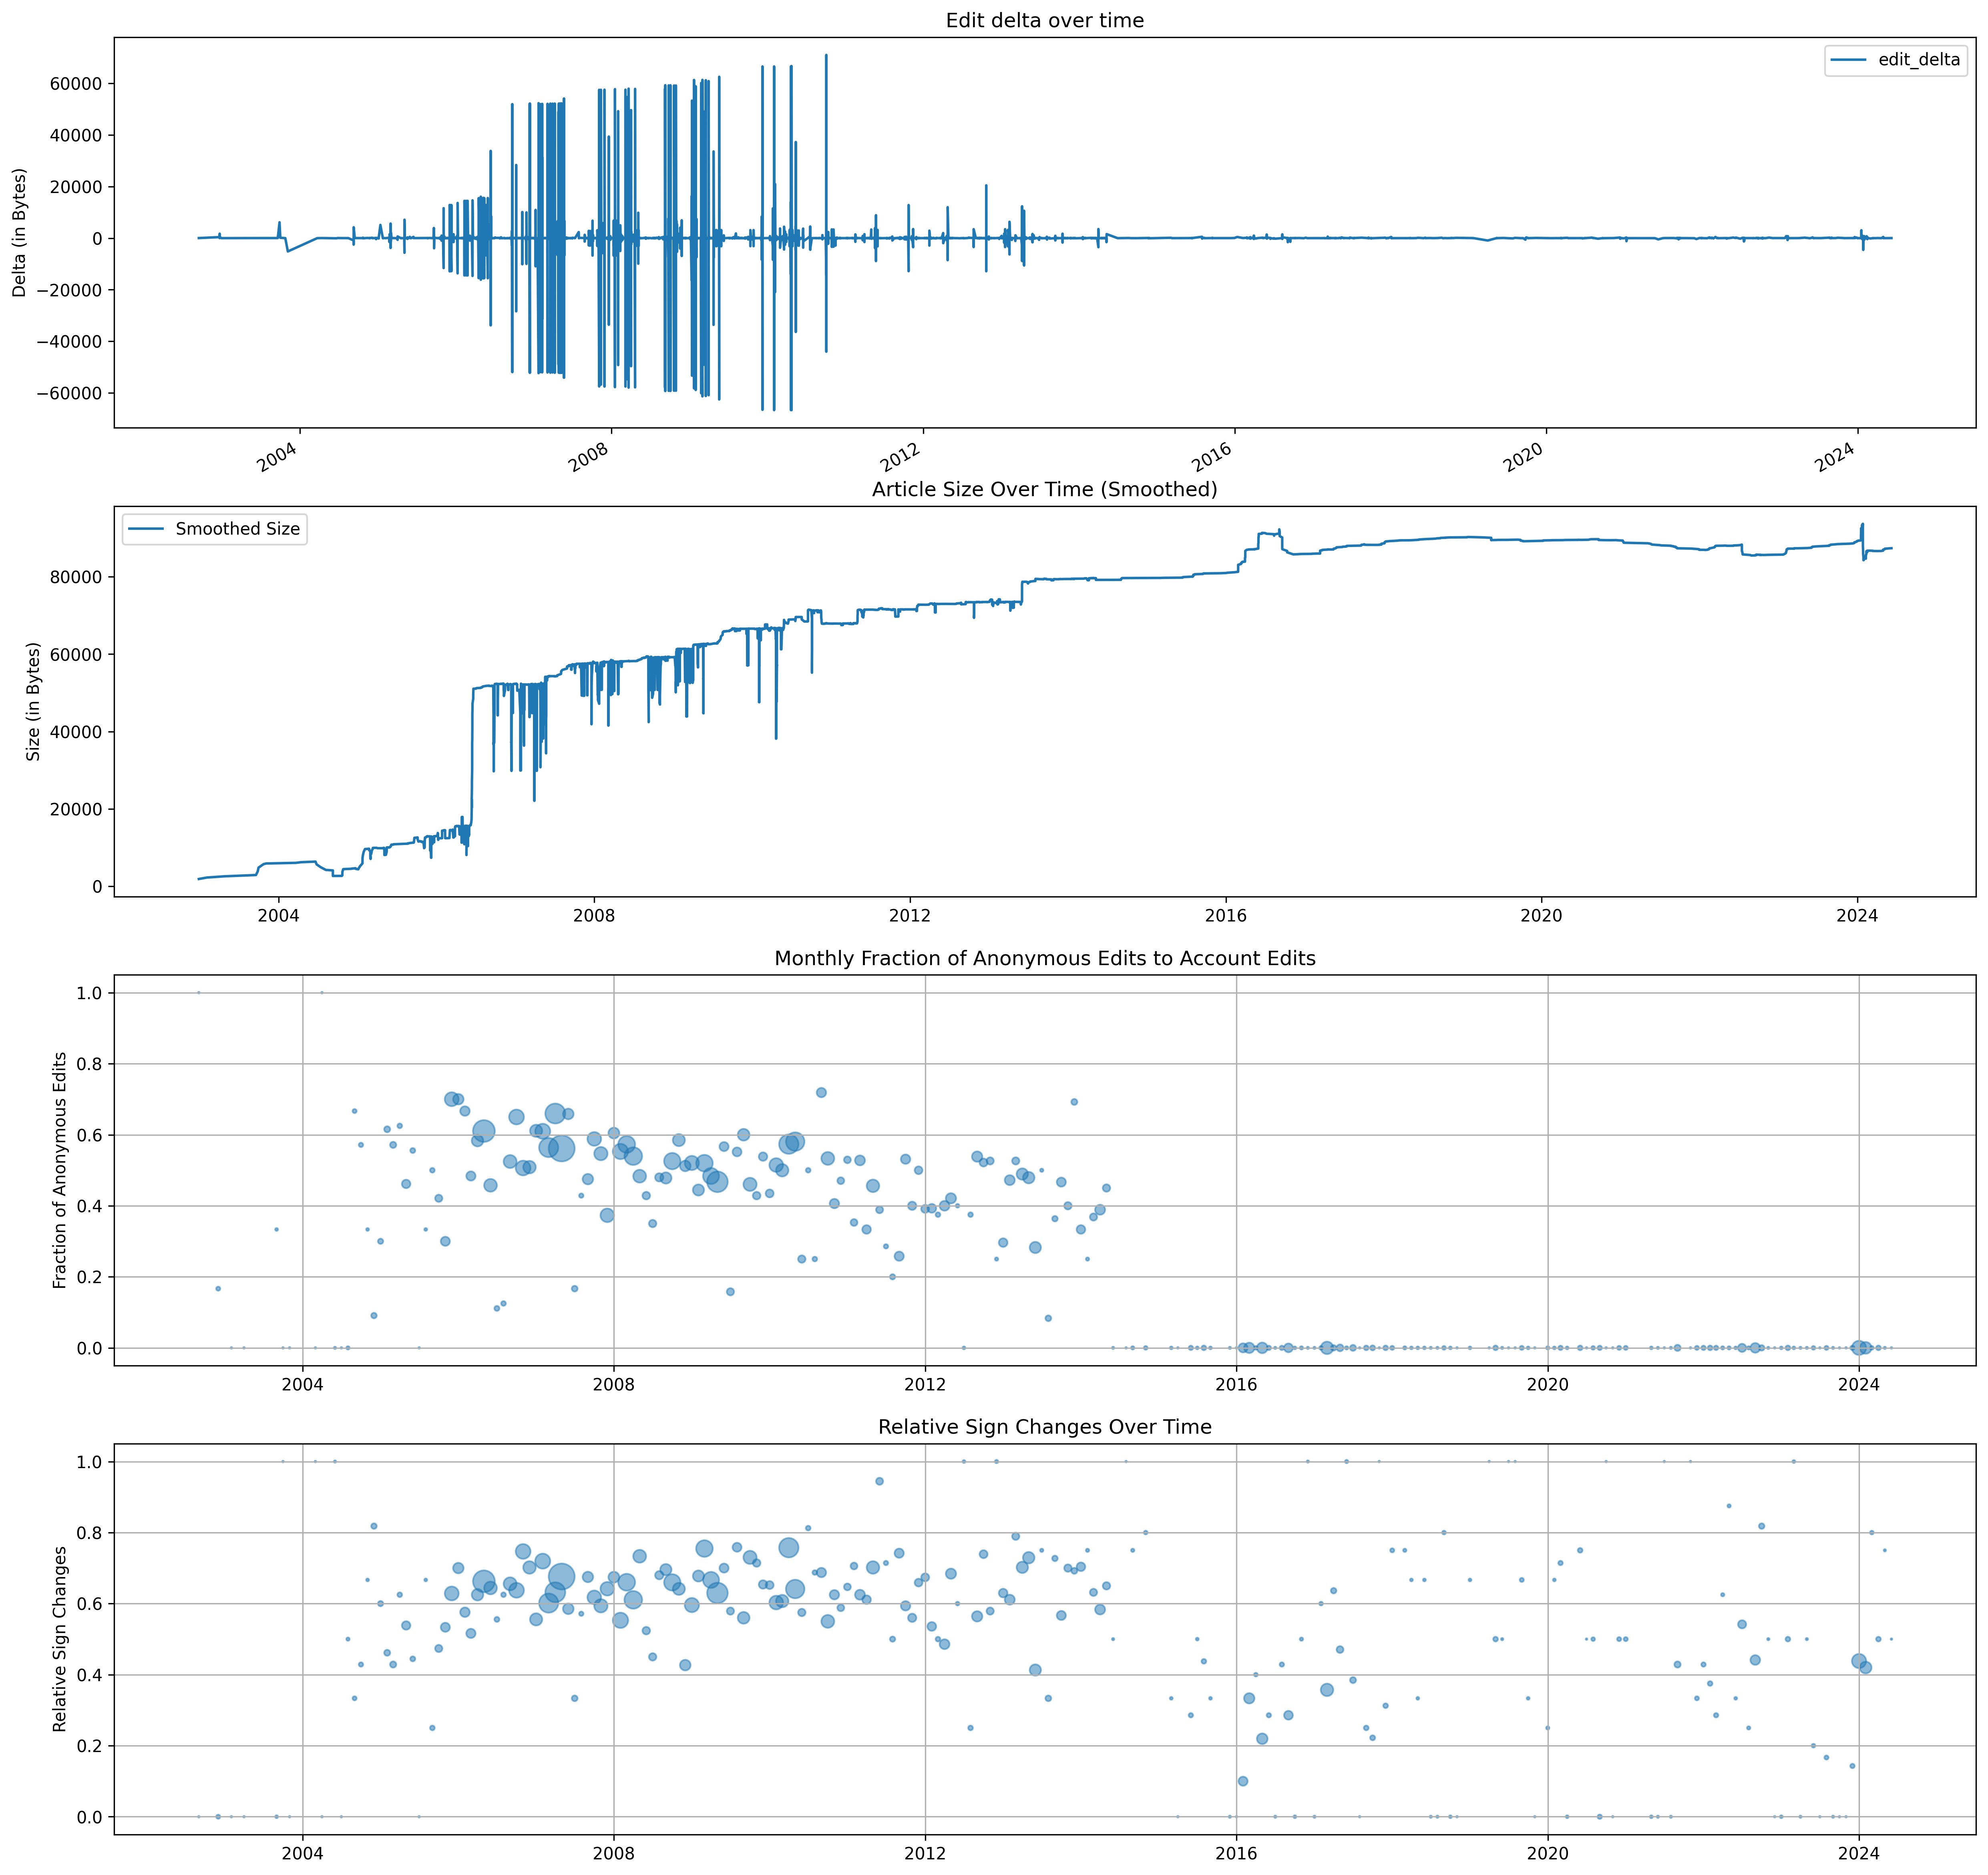

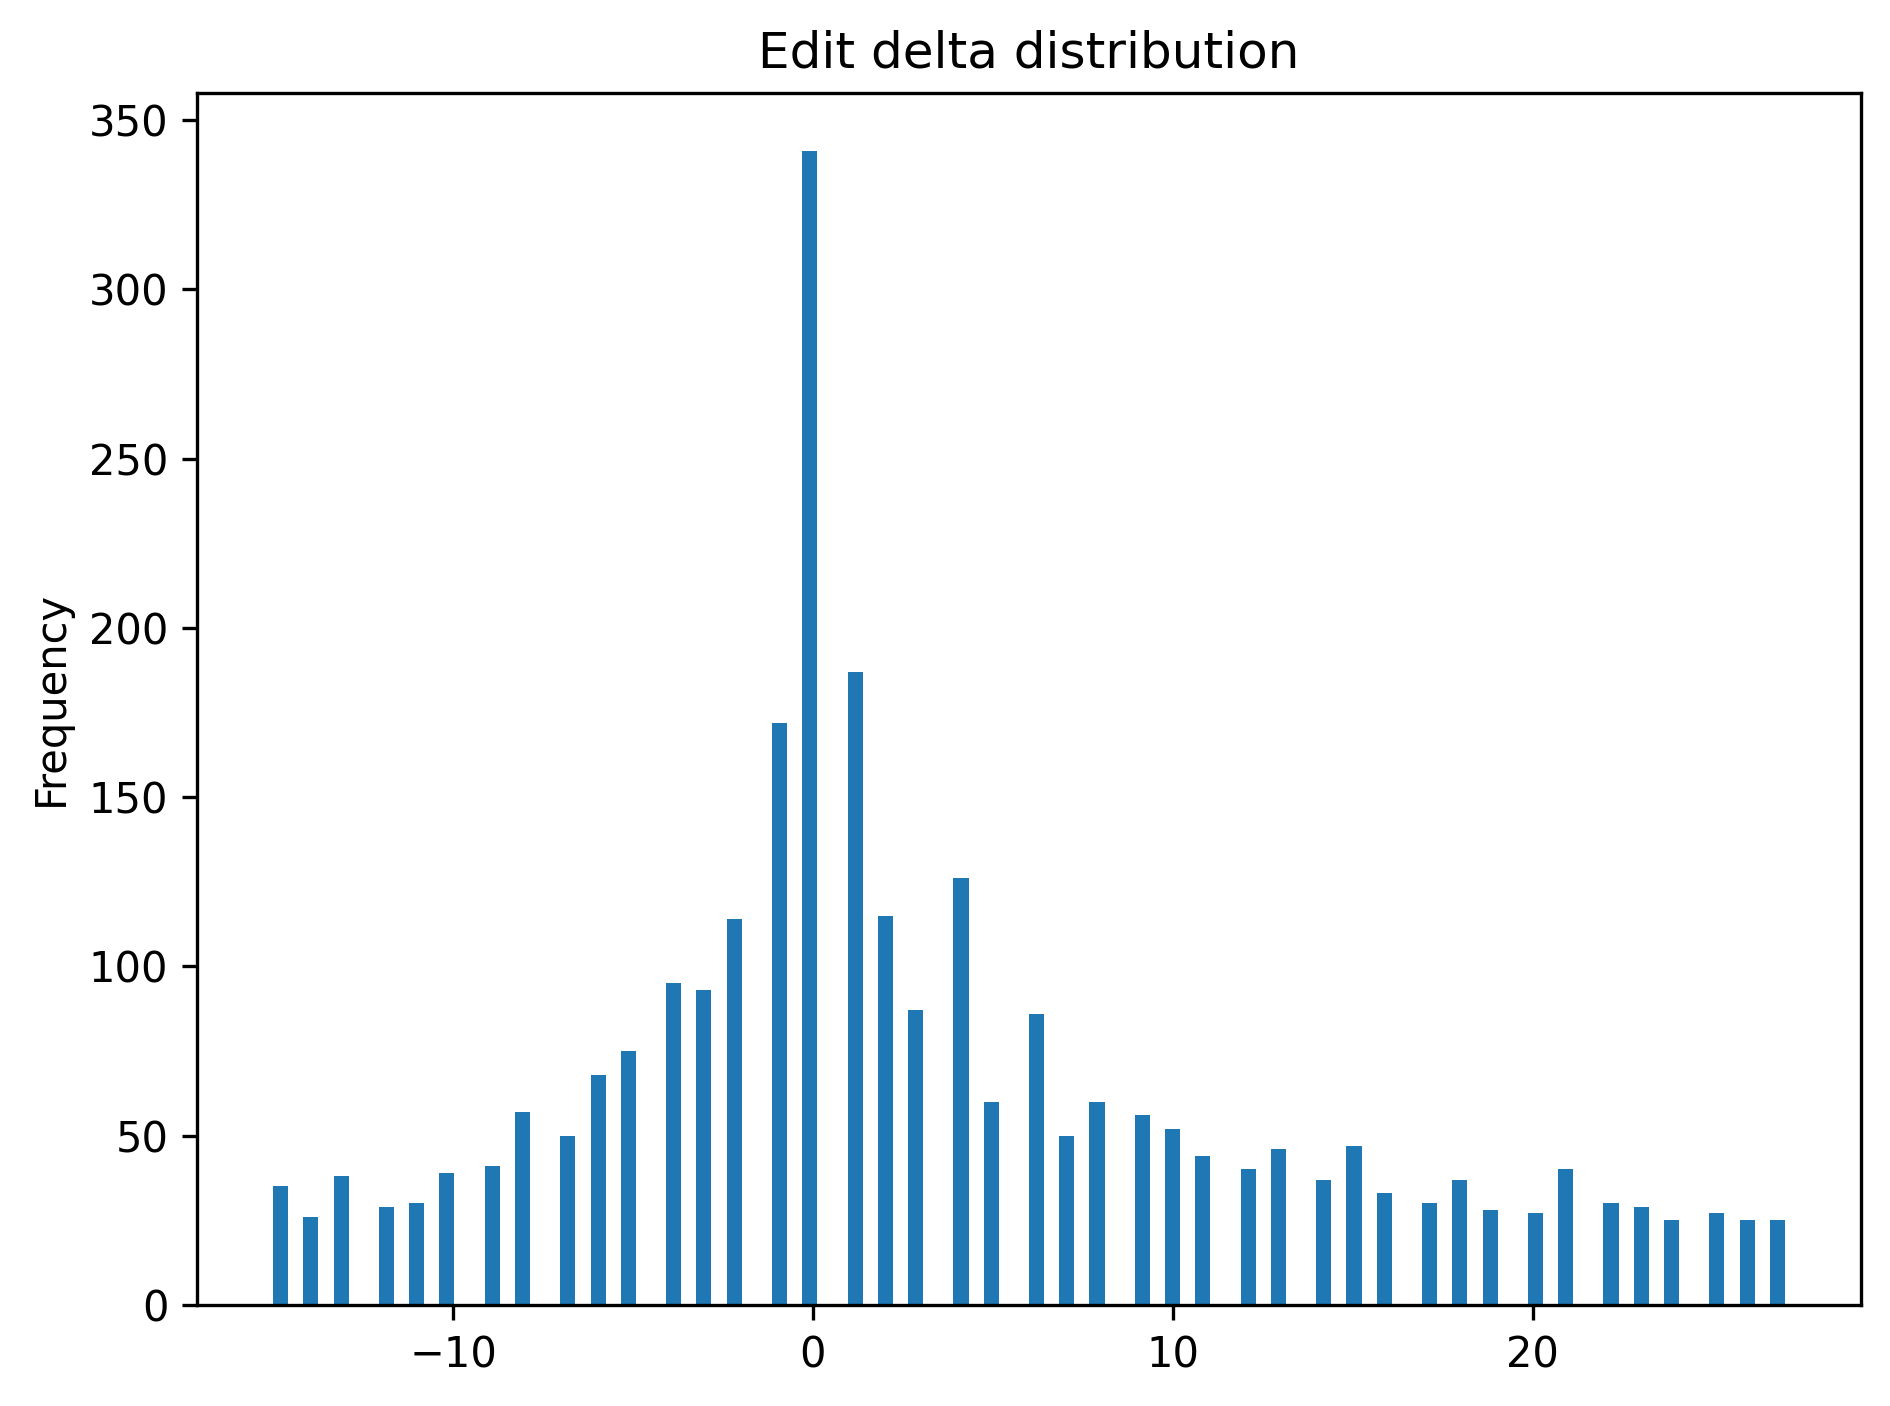

In [3]:
analyze_article_deltas(cw_df, "Battle_of_Antietam", "en")

### Delta Analysis of Ukrainian Soviet Socialist Republic Article

In contrast to the previous article, this article about the Ukrainian Soviet Socialist Republic has fewer distinct periods of contention, instead exhibiting a more consistent growth, with only few marked points where the relative number of sign changes was higher, such as in 2017.

This is also reflected in the Delta Distribution, which is right skewed.

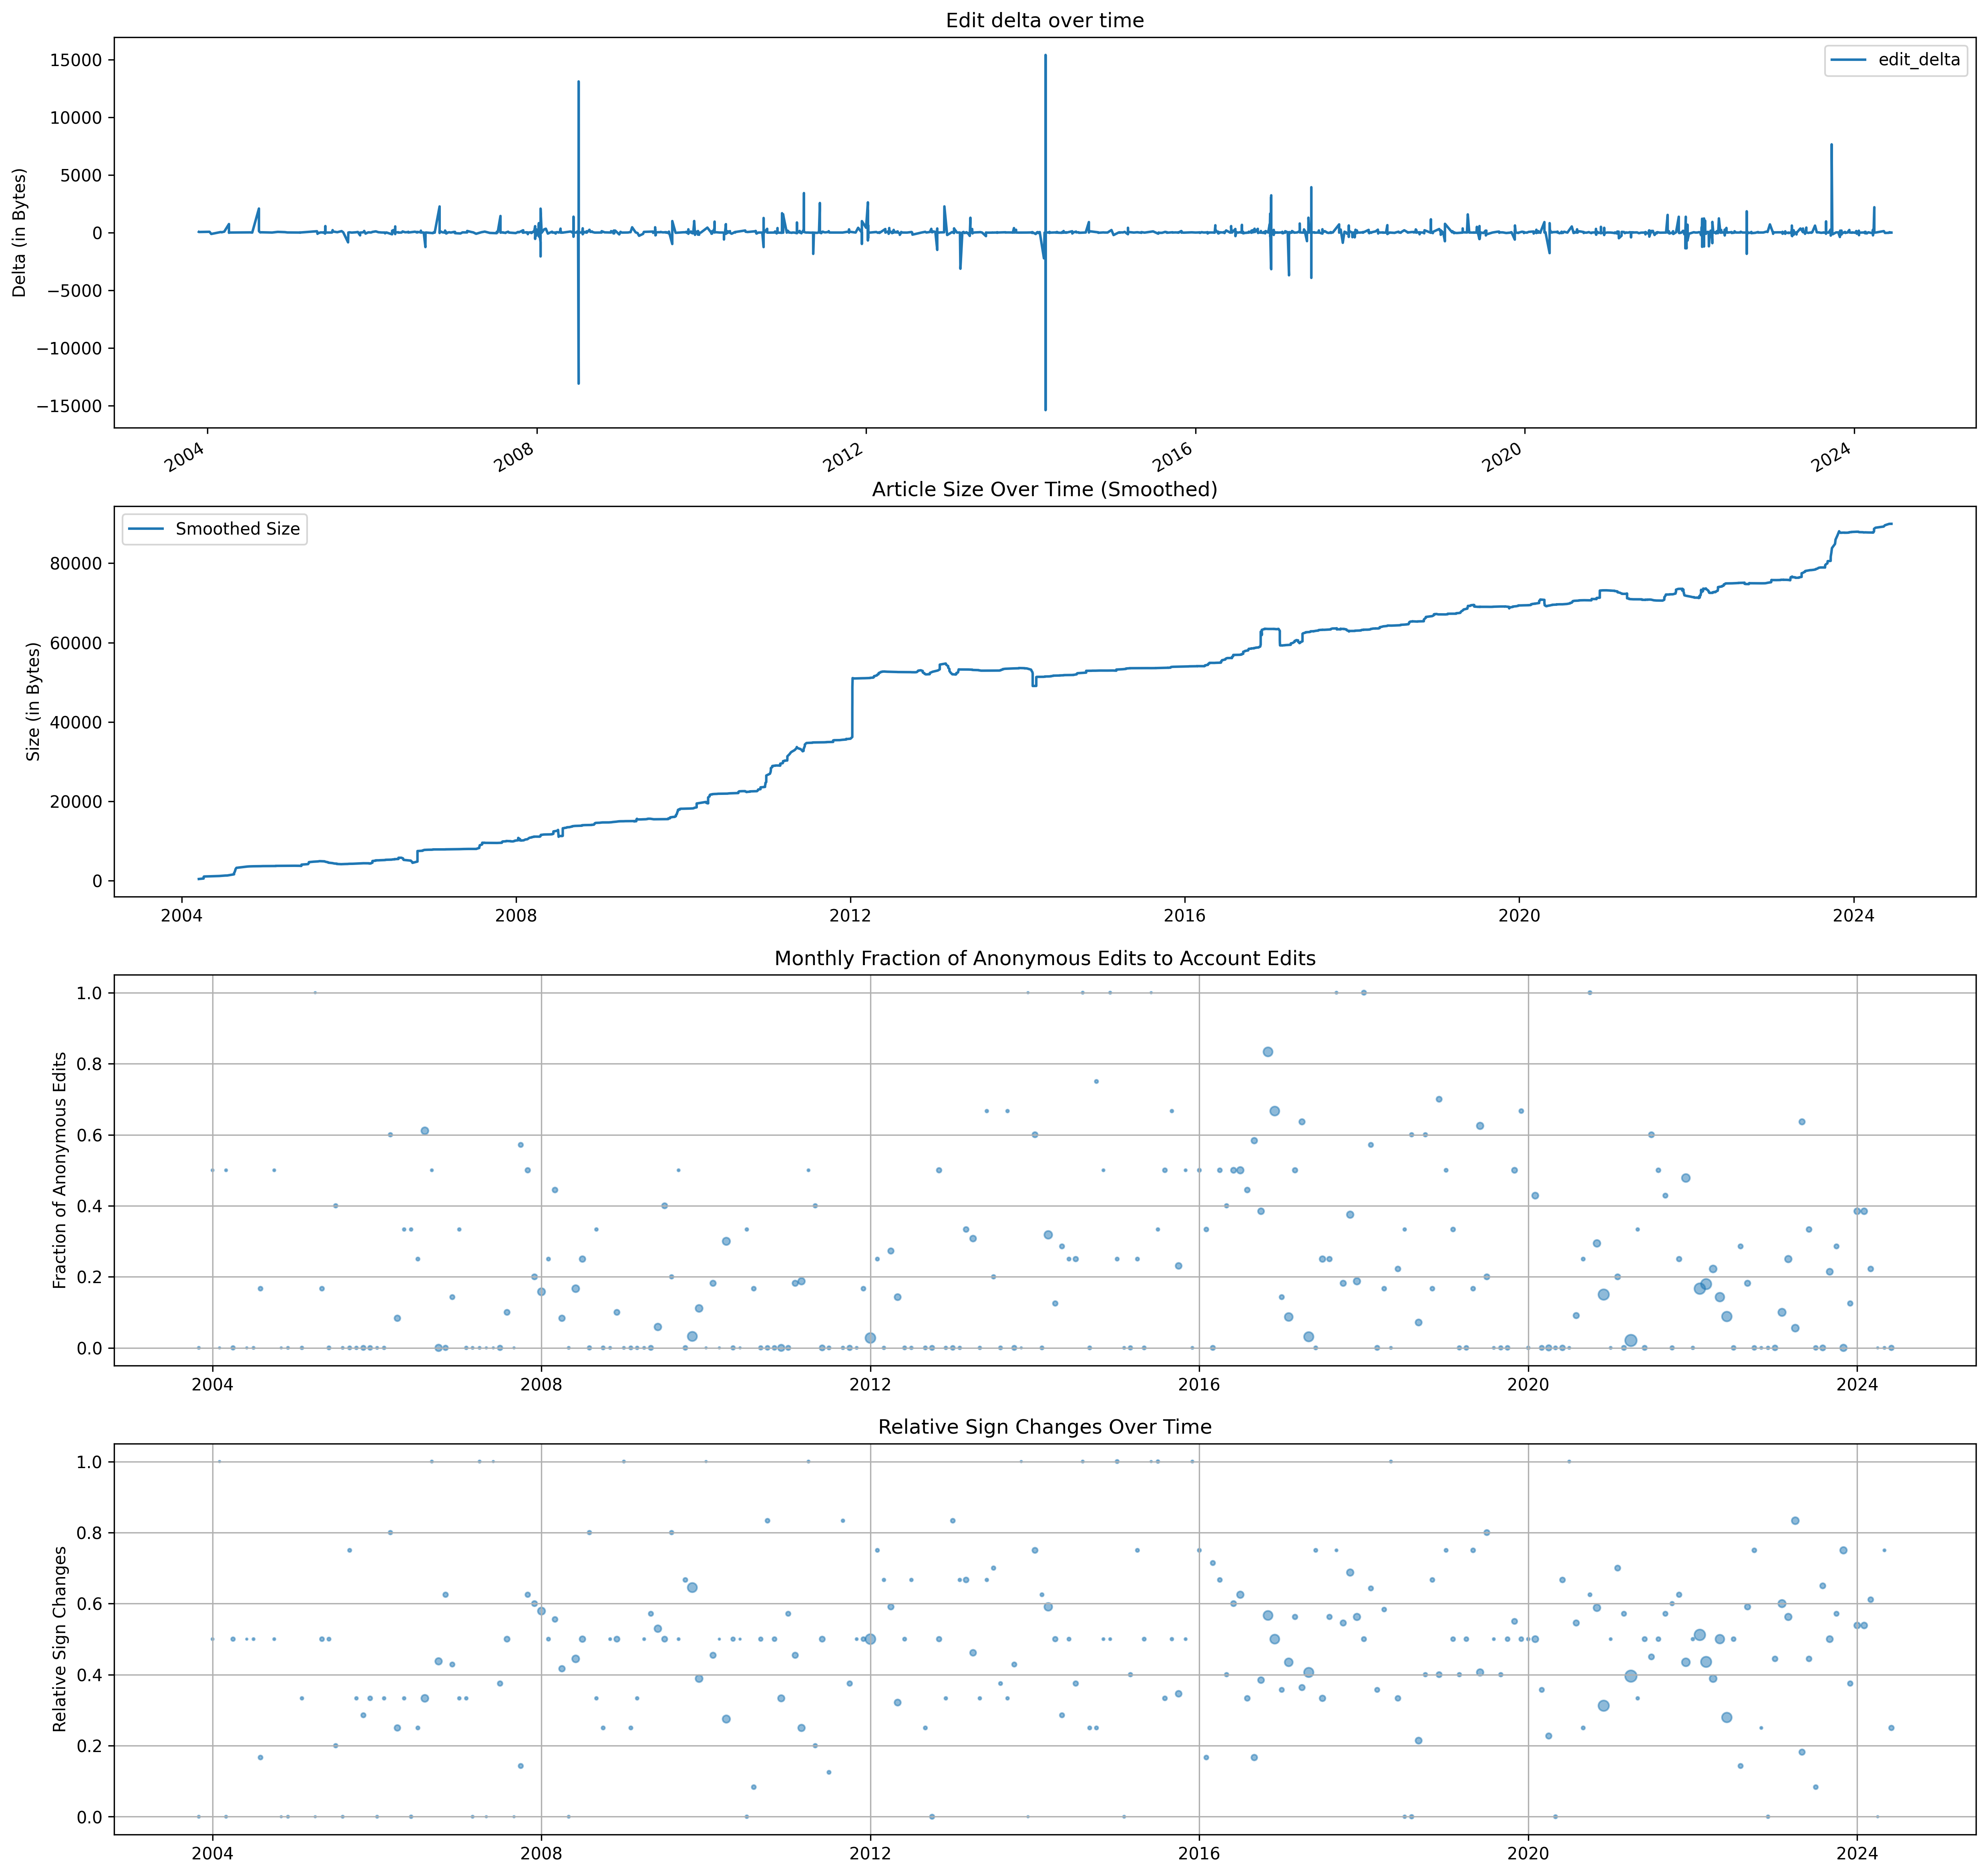

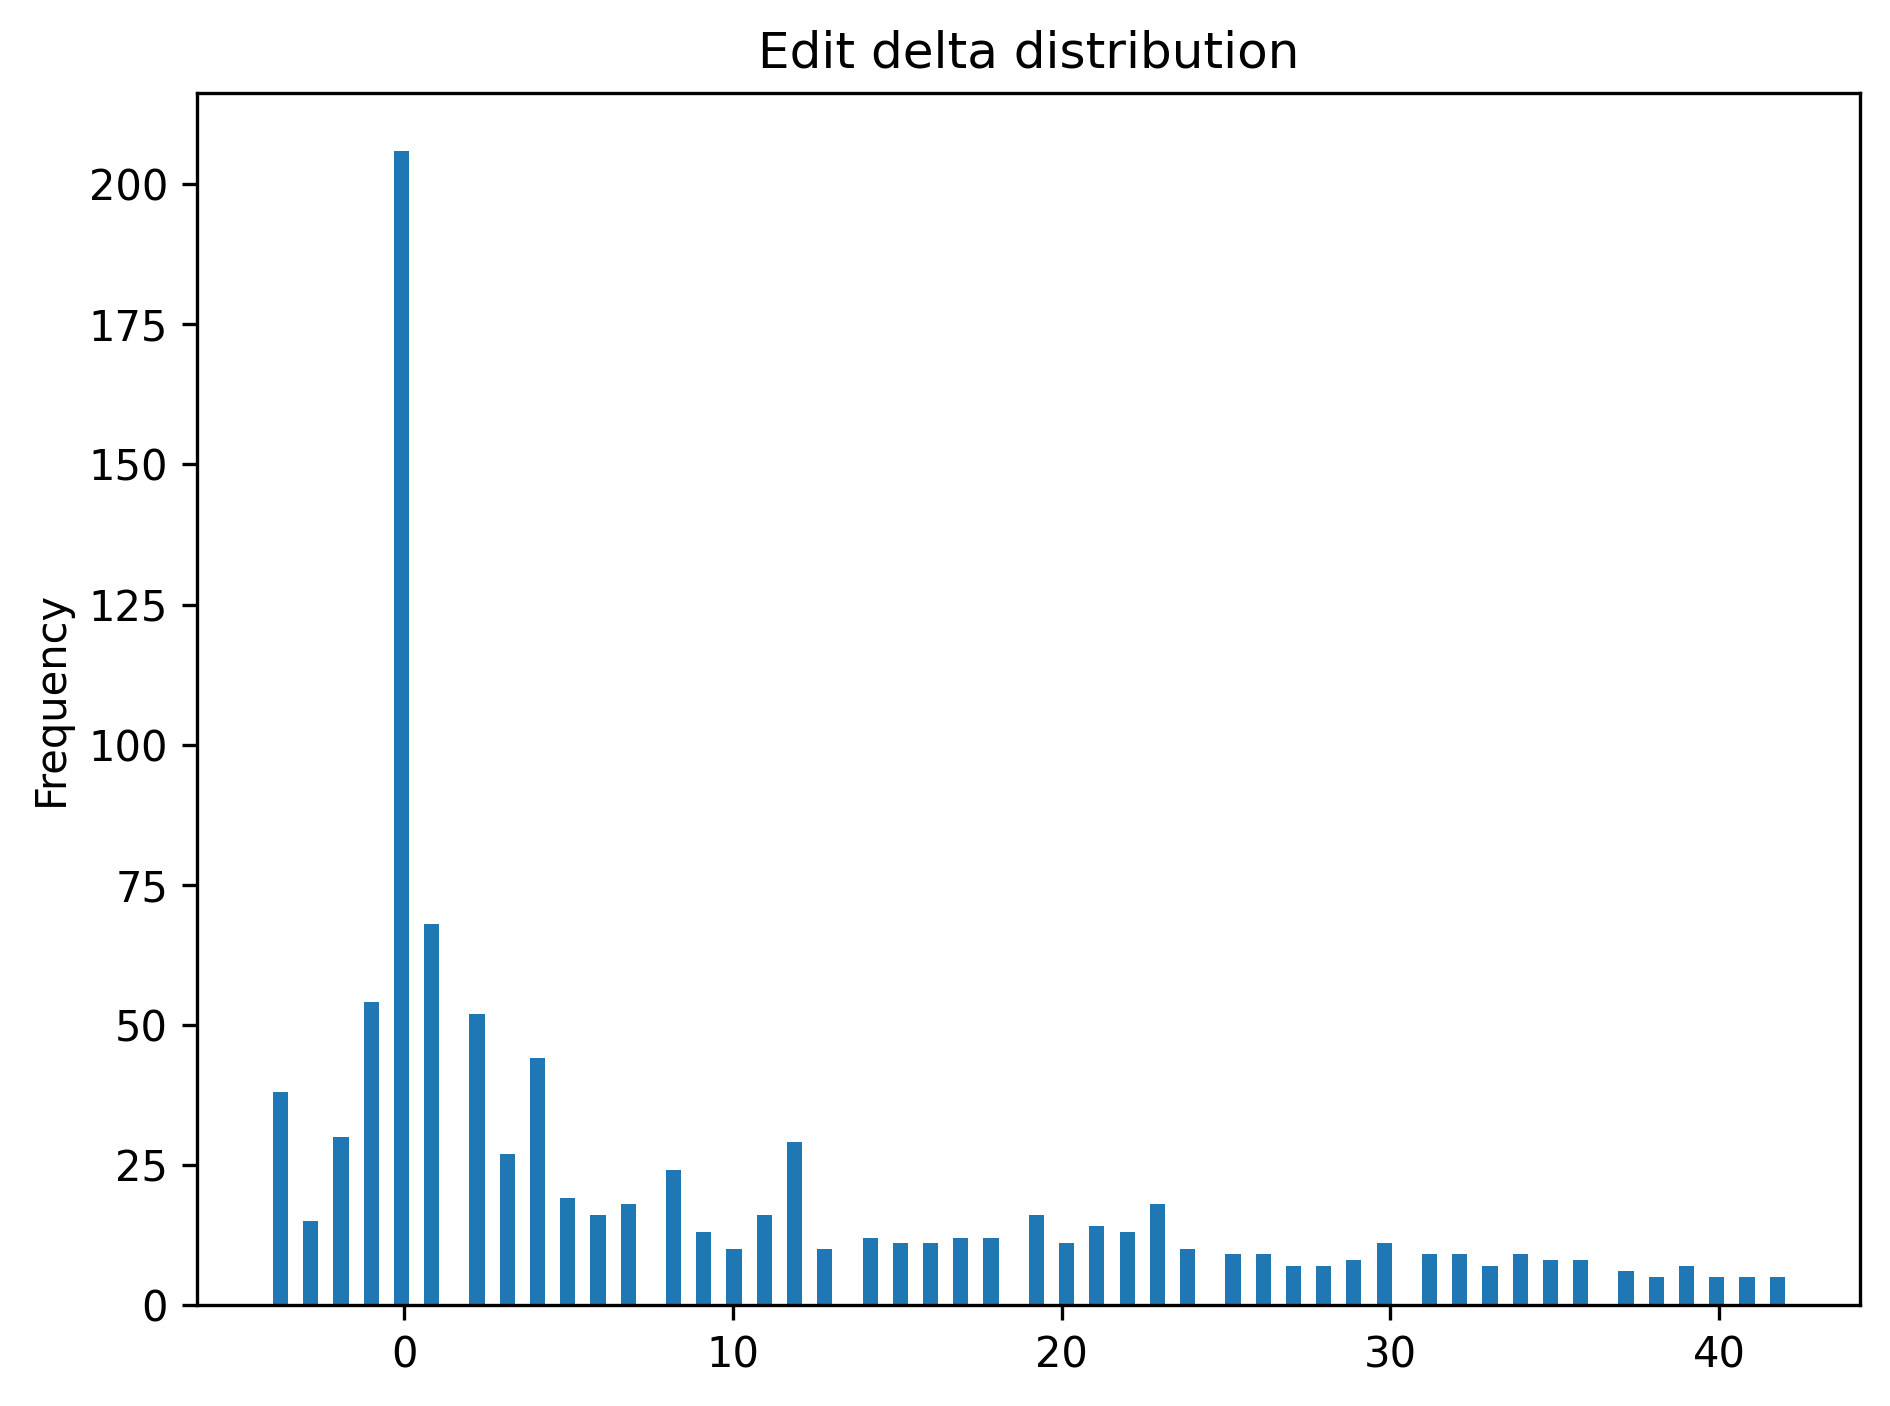

In [4]:
analyze_article_deltas(ua_df, "Ukrainian_Soviet_Socialist_Republic", "en")

### Overall Jerk metric

The `get_overall_jerk` function can take any specified timeperiod on an articles dataframe, and then divides the number of overall sign changes by the number of edits. Thus it indicates how many of an articles overall edits changed the sign of the previous edit, i.e. reverted or restored content. The `get_all_articles_jerk` then iterates a list of articles within a dataframe and sorts them by their overall "jerkiness". This could potentially be used to flag more disputes articles.

In [5]:
def get_article_edit_metadata(df: pd.DataFrame):
    """Returns the earliest edit and num of overall edits for an article df
    * Must be a df filtered for article and language
    """
    earliest_edit = df['timestamp'].min()
    num_edits = len(df)
    return {'earliest_edit': earliest_edit, 'num_edits': num_edits}


def get_overall_jerk(df: pd.DataFrame, start="", end=""):
    """Assumes the df already has
    * edit_delta
    * is filtered for one article and language
    Returns overall jerk for arbitrary specified time period
    """
    # filter if time period specified
    if start: df = df[(df['timestamp'] > start)]
    if end: df = df[(df['timestamp'] < end)]
    return df['sign_change'].sum() / len(df)


def get_all_articles_jerk(article_list, df):
    """Overall analysis of an article's edit deltas
    """
    results = []
    for article in tqdm(article_list):
        df_article = prepare_df(df, article, "en")
        metadata = get_article_edit_metadata(df_article)
        oj = get_overall_jerk(df_article)
        results.append({'article': article, 'overall_jerk': oj} | metadata)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('overall_jerk', ascending=False)
    return results_df

cw_articles = topics["US_Civil_War"]
jerk_df = get_all_articles_jerk(cw_articles, cw_df)
jerk_df


100%|██████████| 45/45 [00:02<00:00, 19.27it/s]


,article,overall_jerk,earliest_edit,num_edits
1,Sherman's_March_to_the_Sea,0.633877,2003-11-13 03:15:20,3619
31,Stonewall_Jackson,0.625221,2002-01-11 03:26:19,7351
34,William_Lloyd_Garrison,0.606415,2002-11-22 06:56:07,3632
24,Joseph_Hooker,0.605011,2003-08-14 00:34:19,1357
38,Battle_of_Antietam,0.604635,2002-09-13 15:05:23,5610
37,Battle_of_the_Wilderness,0.600969,2002-04-13 01:35:02,1857
15,Battle_of_Gettysburg,0.599038,2001-12-20 16:45:13,5821
40,Emancipation_Proclamation,0.595378,2001-10-19 13:32:19,6144
9,United_Daughters_of_the_Confederacy,0.582490,2004-10-27 18:14:08,1679
42,Slavery_in_the_United_States,0.578564,2004-01-18 06:01:23,11131


## User Data Metrics

Here we add a flag to the edit log that indicates if the username was just an ip address, i.e. an anonymous contributor. We then use a piechart to show the proportion between the two types of users, both in terms of total edits and unique editors. Of course this is limited to just the data we fetched, not necessarily representative of Wikipedia in general.

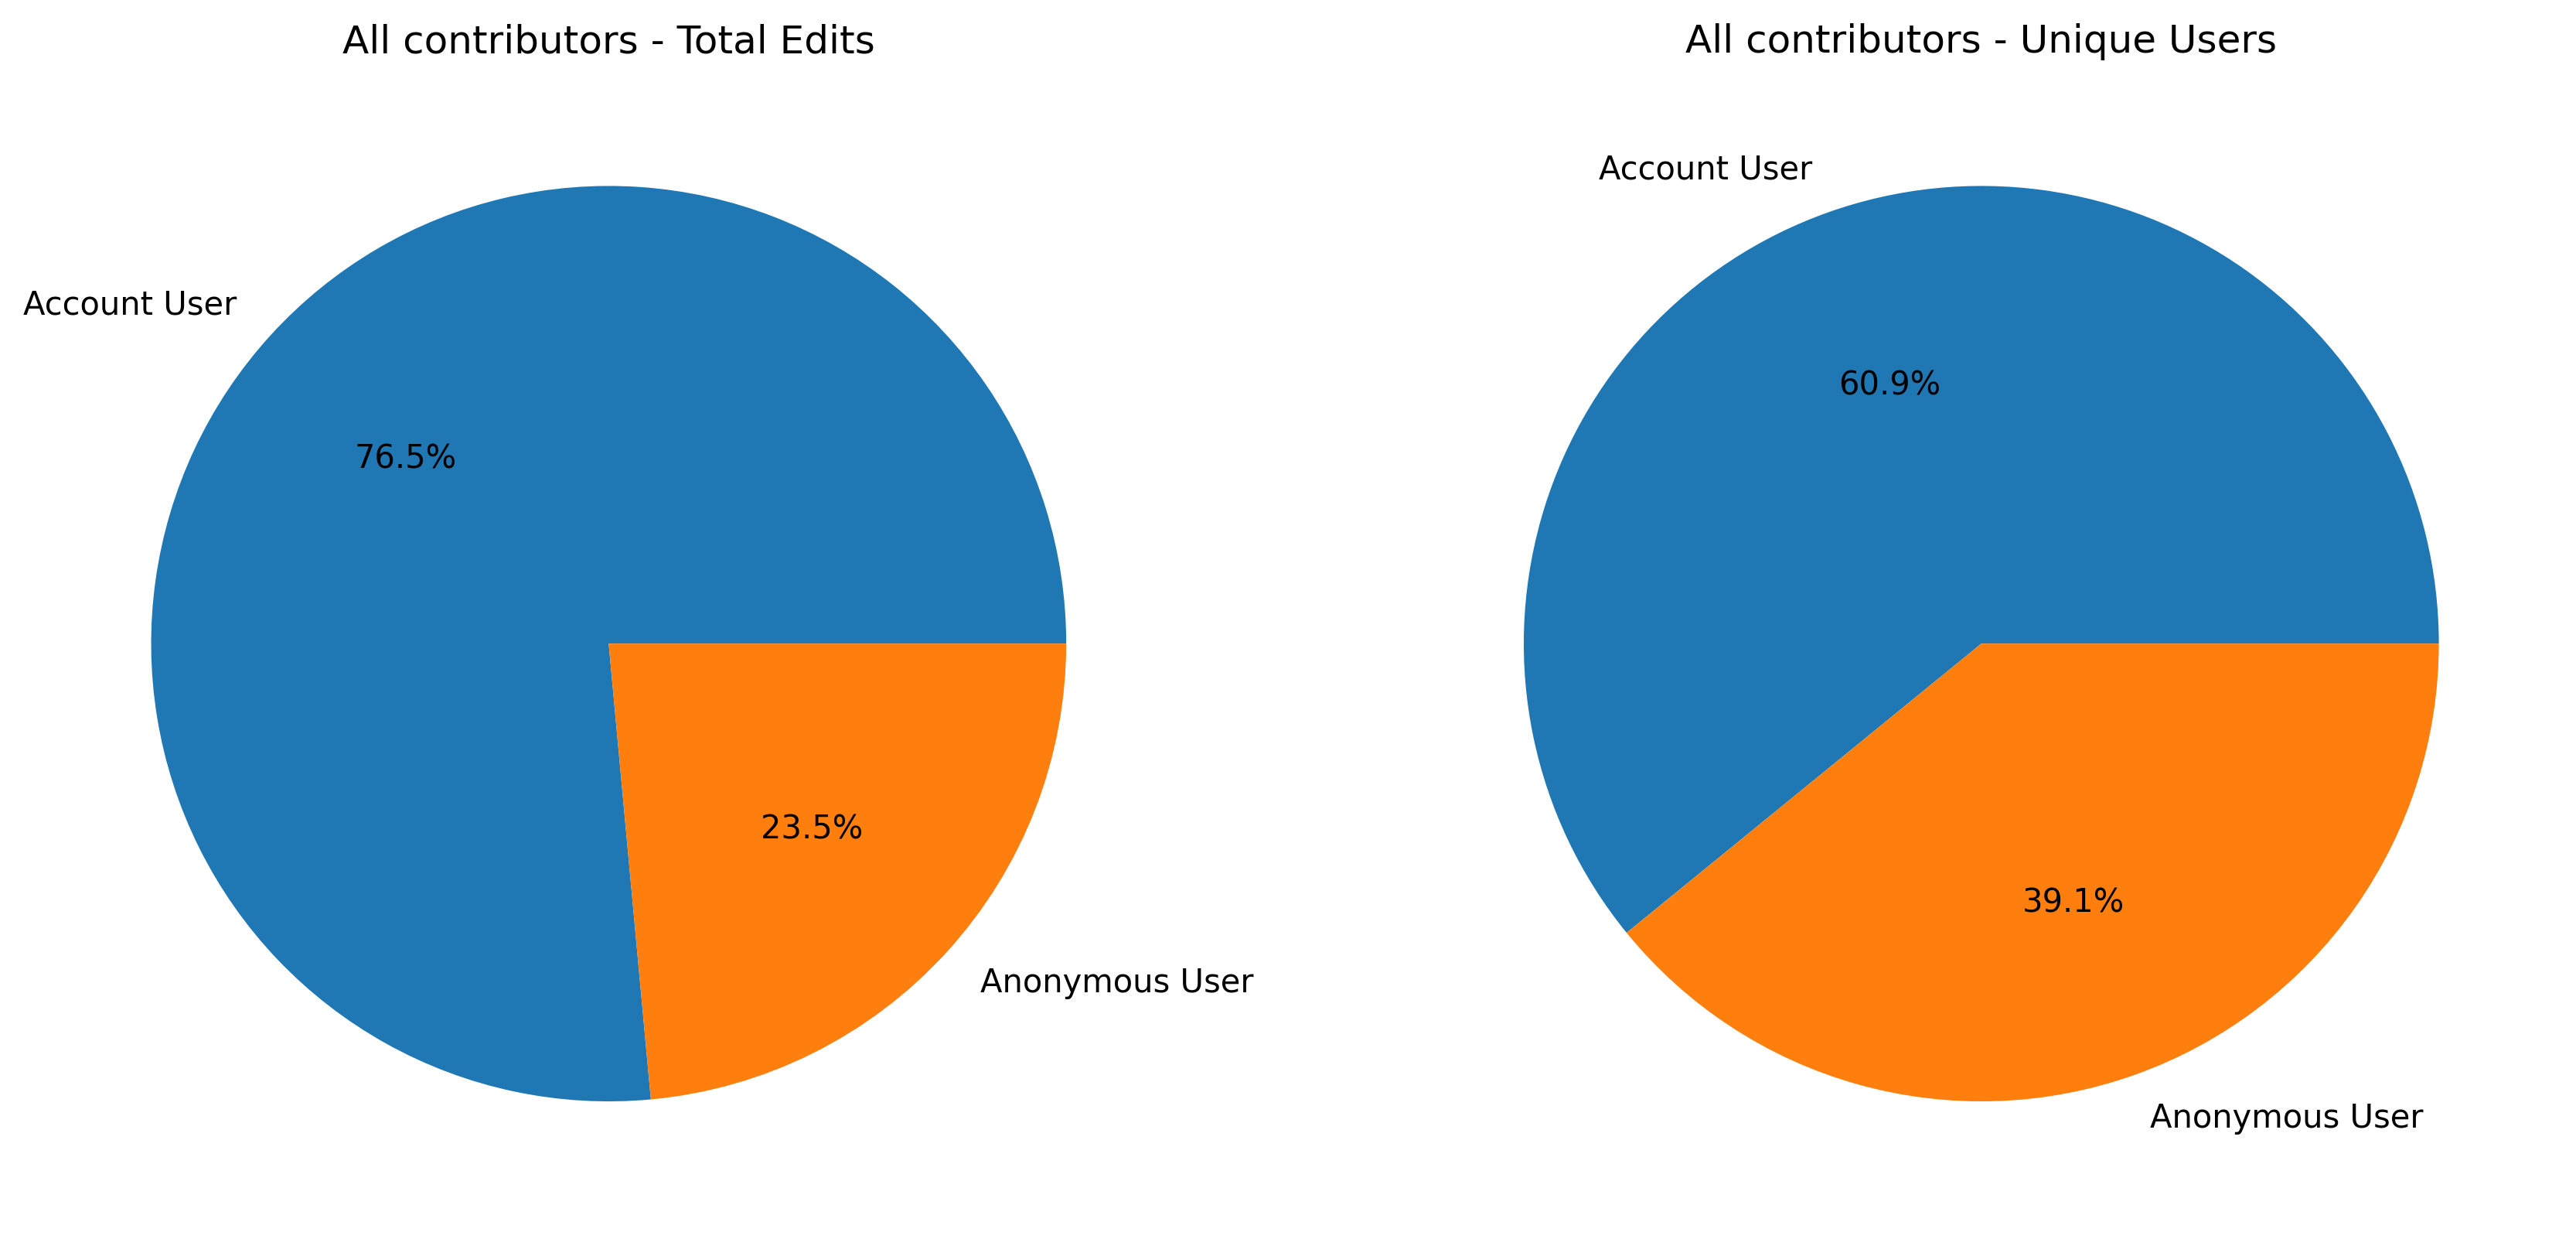

In [6]:
def piechart_user_types(df: pd.DataFrame, title: str):
    """Checks which unames are ip adresses and plots a pie chart of the
    proportion of anonymous vs account users for both total edits and unique users
    """
    # regex match ip adresses and flag 'em
    ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    df["is_anon_uname"] = df['user'].str.match(ip_pattern)
    df["frac_edits_on_this_article"] = df["article_edits"] / df["total_edits"]

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    # First Pie Plot: Distribution by total edits
    plt.sca(axs[0])
    plt.title(f"{title} - Total Edits")
    user_types = df['is_anon_uname'].map({True: 'Anonymous User', False: 'Account User'})
    user_types.value_counts().plot.pie(autopct='%1.1f%%', labels=['Account User', 'Anonymous User'])
    plt.ylabel('')

    # Second Pie Plot: Distribution by unique users
    plt.sca(axs[1])
    plt.title(f"{title} - Unique Users")
    unique_users_df = df.drop_duplicates(subset='user')
    unique_user_types = unique_users_df['is_anon_uname'].map({True: 'Anonymous User', False: 'Account User'})
    unique_user_types.value_counts().plot.pie(autopct='%1.1f%%', labels=['Account User', 'Anonymous User'])
    plt.ylabel('')
    plt.gcf().set_dpi(300)
    plt.show()


piechart_user_types(all_df, "All contributors")	